In [12]:
import pygmt 
import xarray as xr 
import pandas as pd 
import numpy as np
import os
import glob

In [23]:
resname = '5'
model = xr.open_dataset('TGR_data'+os.sep+'tomoDD09'+os.sep+f'TGR_2009_checkerboard_{resname}_19.h5')
model = model.where(model.depth <= 10,drop=True)
names = ['evtid','latitude','longitude','depth','X','Y','Z','ex','ey','ez',
         'year','month','day','hour','minute','second','magnitude',
         'nccp','nccs','nctp','ncts','rcc','rct','cid']
catalog = pd.read_csv('TGR_data/tomoDD09/RealDataInversion/Output_Files/tomoDD.reloc',sep='\s+',names=names)
cities = pd.read_csv('TGR_data/geology/SX_citylonlat.txt',sep='\s+',encoding='gbk')
stations = pd.read_csv('TGR_data/tomoDD09/ph2dt/station.dat',sep='\s+',names=['name','latitude','longitude','elevation'])

interval,label = 100,'DWS=100'
intervalr,labelr = 0.7,'RES=0.7' # >2km
#intervalr,labelr = 0.6,'RES=0.6' # =2km

#interval,label = 20,'DWS=20' # 1km
#intervalr,labelr = 0.55,'RES=0.55'

wv = 'p'

In [24]:
lons,lats = model.longitude.values,model.latitude.values
dx,dy = np.diff(lons)[0],np.diff(lats)[0]
dx,dy = 0,0
region = [lons[0]-dx/2,lons[-1]+dx/2,lats[0]-dy/2,lats[-1]+dy/2]
idx_lon,idx_lat = np.searchsorted(lons,110+24/60),np.searchsorted(lats,31+5/60)
clon,clat = lons[idx_lon],lats[idx_lat]

# 插值
dx=dy=0.1
lons,lats = model.longitude.values,model.latitude.values
new_lons = np.linspace(lons[0],lons[-1],10*len(lons))
new_lats = np.linspace(lats[0],lats[-1],10*len(lats))
model = model.interp(longitude=new_lons,latitude=new_lats)

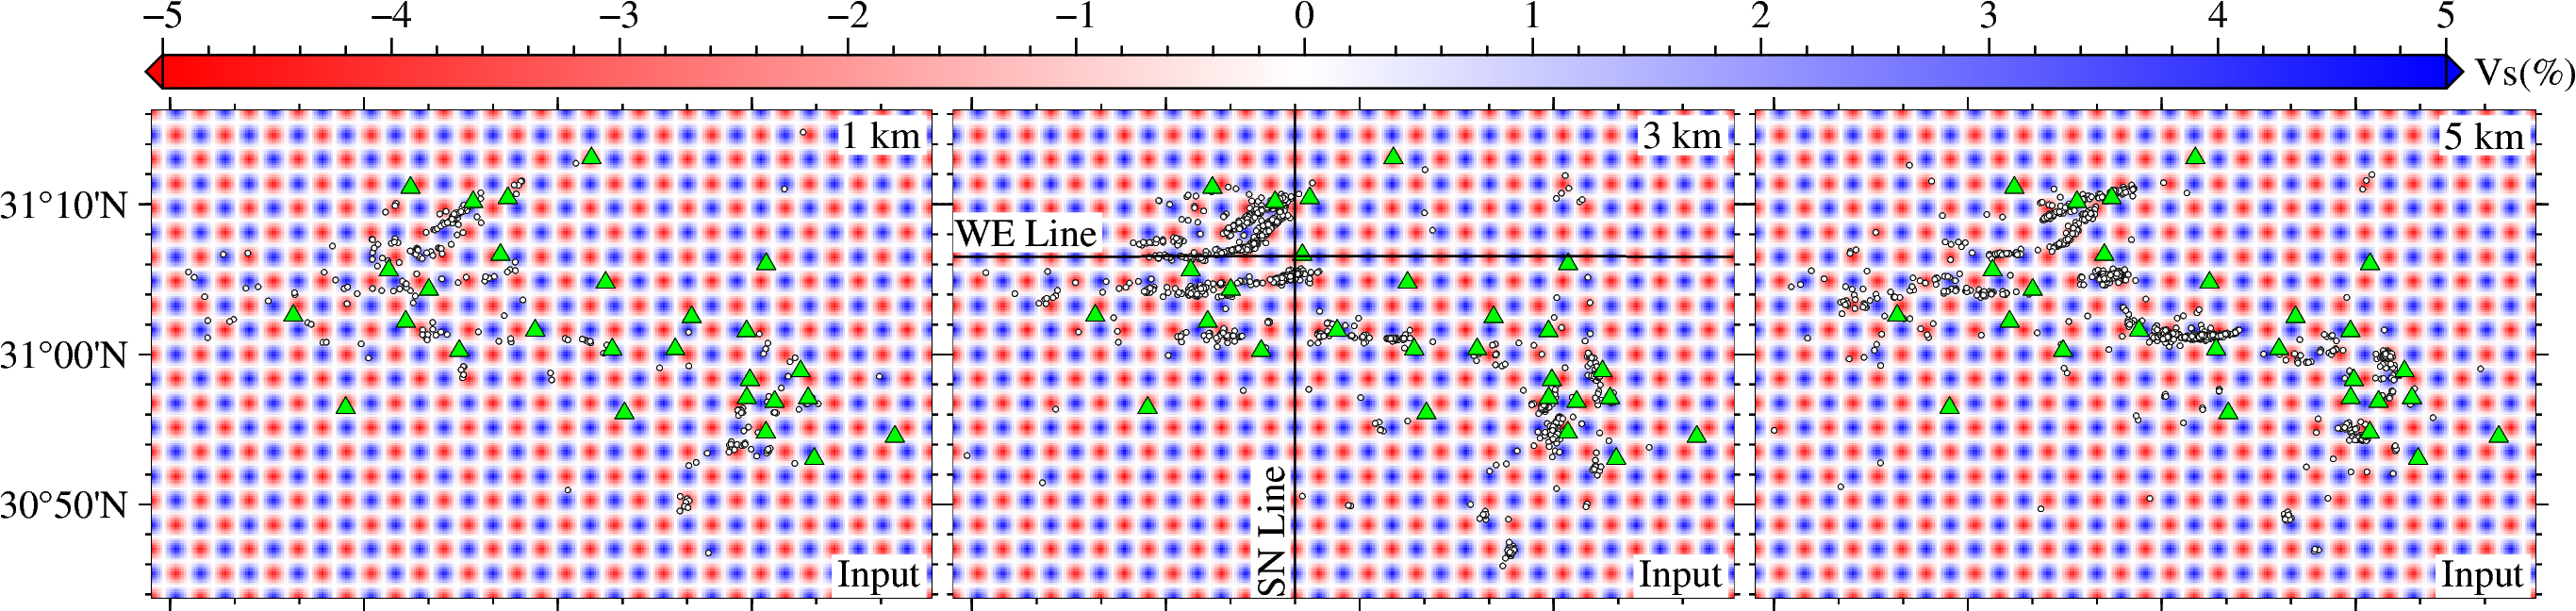

In [25]:
fig = pygmt.Figure()
pygmt.makecpt(cmap='polar',series=[-5,5,0.1],continuous=True,background=True,reverse=True,output='chk.cpt')
pygmt.config(FONT='10p,4',COLOR_NAN='128',MAP_FRAME_TYPE='plain',MAP_FRAME_PEN='0.5p')
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','Wsen'])
with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"-Wh ->{tmpfile.name}")
        map_height = tmpfile.read().strip()
map_height = float(map_height)

depth = 1
reloc = catalog[(catalog.depth >= depth-1)&(catalog.depth<=depth+1)]
data = model.sel(depth=depth)
grid = (data[f'v{wv}_true'] - data[f'v{wv}_0'])/data[f'v{wv}_0']
#grid = data['vp_perc']
fig.grdimage(grid=grid*100,cmap='chk.cpt')
fig.plot(x=reloc.longitude,y=reloc.latitude,style='c0.02i',fill='white',pen='0.1p')
fig.plot(x=stations.longitude,y=stations.latitude,style='t0.2c',fill='green',pen='0.1p,black')
fig.text(position='cTR',text='{} km'.format(depth),offset='-0.1c/-0.1c',fill='white')
fig.text(position='cBR',text='Input',fill='white',offset='-0.1c/0.1c')
fig.colorbar(position='jTL+w20.5c/0.3c+o0.1c/-0.5c+m+e+h',frame=['xaf',f'y+lV{wv}(%)'],cmap='chk.cpt')


fig.shift_origin(xshift='7.2c')
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','wsen'])
depth = 3
reloc = catalog[(catalog.depth >= depth-1)&(catalog.depth<=depth+1)]
data = model.sel(depth=depth)
grid = (data[f'v{wv}_true'] - data[f'v{wv}_0'])/data[f'v{wv}_0']
fig.grdimage(grid=grid*100,cmap='chk.cpt')
fig.plot(x=reloc.longitude,y=reloc.latitude,style='c0.02i',fill='white',pen='0.1p')
fig.plot(x=stations.longitude,y=stations.latitude,style='t0.2c',fill='green',pen='0.1p,black')

# plot line
fig.plot(x=[region[0],region[1]],y=[clat,clat],pen='0.5p')
fig.plot(x=[clon,clon],y=[region[2],region[3]],pen='0.5p')
fig.text(x=region[0],y=clat,text='WE Line',fill='white',justify='BL',offset='0c/0.1c')
fig.text(x=clon,y=region[2],text='SN Line',fill='white',justify='BL',angle=90,offset='-0.1c/0.0c')
fig.text(position='cTR',text='{} km'.format(depth),offset='-0.1c/-0.1c',fill='white')
fig.text(position='cBR',text='Input',fill='white',offset='-0.1c/0.1c')

fig.shift_origin(xshift='7.2c')
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','wsen'])
depth = 5
reloc = catalog[(catalog.depth >= depth-1)&(catalog.depth<=depth+1)]
data = model.sel(depth=depth)
grid = (data[f'v{wv}_true'] - data[f'v{wv}_0'])/data[f'v{wv}_0']
fig.grdimage(grid=grid*100,cmap='chk.cpt')
fig.plot(x=reloc.longitude,y=reloc.latitude,style='c0.02i',fill='white',pen='0.1p')
fig.plot(x=stations.longitude,y=stations.latitude,style='t0.2c',fill='green',pen='0.1p,black')
fig.text(position='cTR',text='{} km'.format(depth),offset='-0.1c/-0.1c',fill='white')
fig.text(position='cBR',text='Input',fill='white',offset='-0.1c/0.1c')

fig.show()

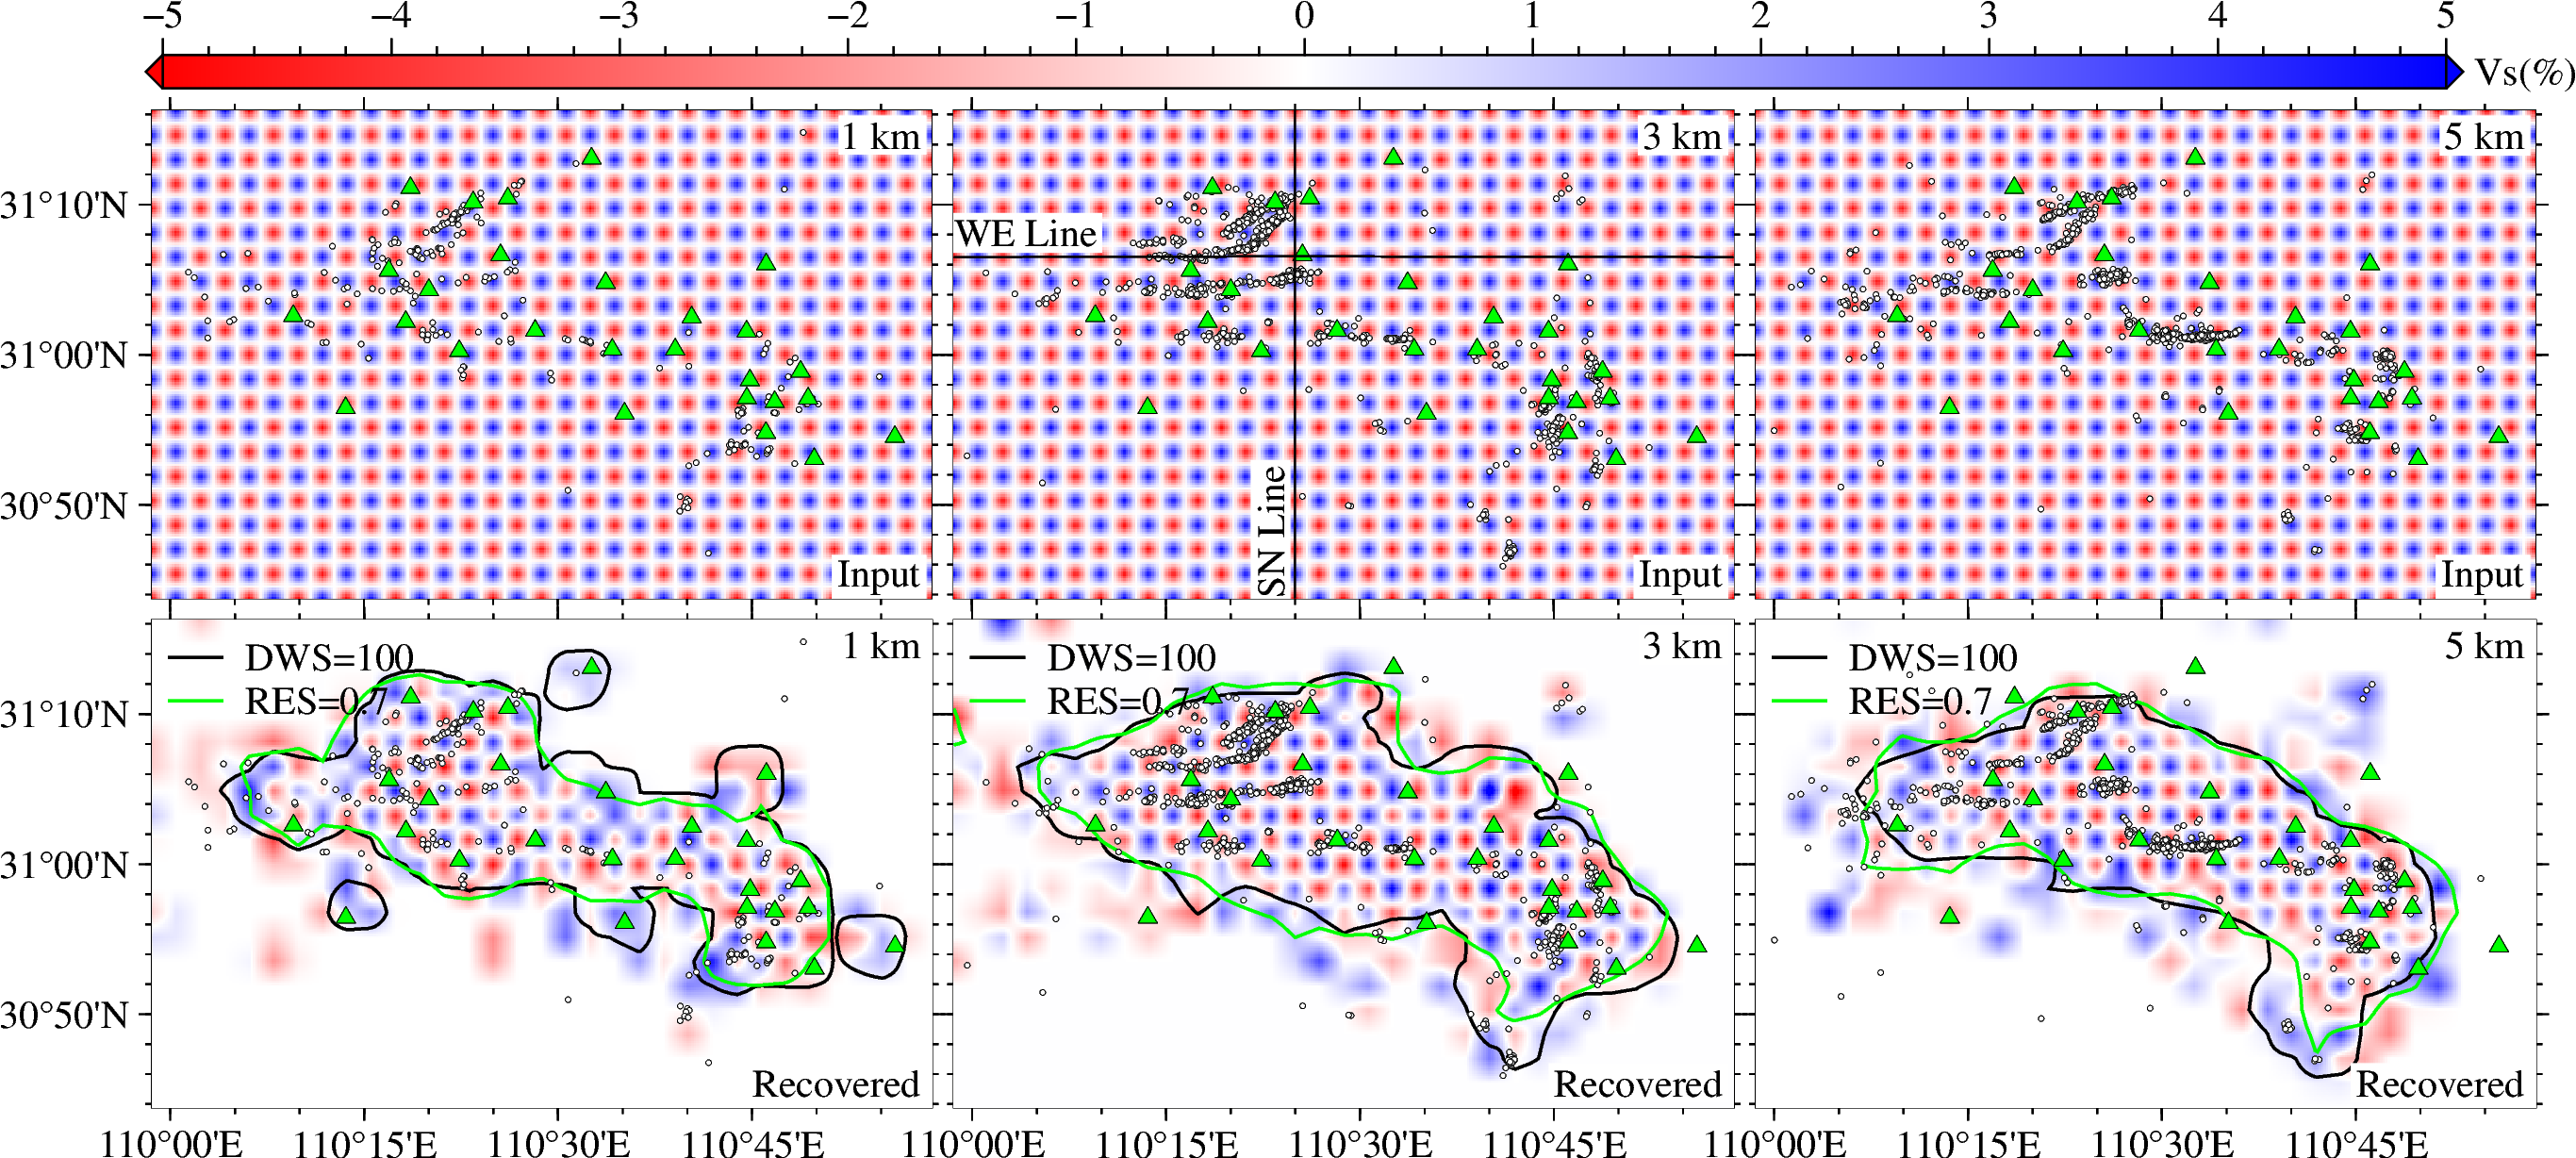

In [26]:

fig.shift_origin(xshift='-{}c'.format(7.2*2),yshift='-{}c'.format(map_height+0.2))
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','WSen'])
# depth=1
depth = 1
reloc = catalog[(catalog.depth >= depth-1)&(catalog.depth<=depth+1)]
data = model.sel(depth=depth)
grid = data[f'v{wv}_perc']
dwsp = data[f'dws{wv}']
resp = data[f'res_{wv}']
#
fig.grdimage(grid=grid*100,cmap='chk.cpt')
fig.grdcontour(grid=dwsp,interval=interval,limit=[interval,interval],pen='0.7p,black',label=label)
fig.grdcontour(grid=resp,interval=intervalr,limit=[intervalr,intervalr],pen='0.7p,green',label=labelr)
fig.plot(x=reloc.longitude,y=reloc.latitude,style='c0.02i',fill='white',pen='0.1p')
fig.plot(x=stations.longitude,y=stations.latitude,style='t0.2c',fill='green',pen='0.1p,black')
fig.text(position='cTR',text='{} km'.format(depth),offset='-0.1c/-0.1c',fill='white')
fig.text(position='cBR',text='Recovered',fill='white',offset='-0.1c/0.1c')
fig.legend(position='jTL')

fig.shift_origin(xshift='7.2c')
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','wSen'])
depth = 3
reloc = catalog[(catalog.depth >= depth-1)&(catalog.depth<=depth+1)]
data = model.sel(depth=depth)
grid = data[f'v{wv}_perc']
dwsp = data[f'dws{wv}']
resp = data[f'res_{wv}']
fig.grdimage(grid=grid*100,cmap='chk.cpt')
fig.grdcontour(grid=dwsp,interval=interval,limit=[interval,interval],pen='0.7p,black',label=label)
fig.grdcontour(grid=resp,interval=intervalr,limit=[intervalr,intervalr],pen='0.7p,green',label=labelr)
fig.plot(x=reloc.longitude,y=reloc.latitude,style='c0.02i',fill='white',pen='0.1p')
fig.plot(x=stations.longitude,y=stations.latitude,style='t0.2c',fill='green',pen='0.1p,black')
fig.text(position='cTR',text='{} km'.format(depth),offset='-0.1c/-0.1c',fill='white')
fig.text(position='cBR',text='Recovered',fill='white',offset='-0.1c/0.1c')
fig.legend(position='jTL')

fig.shift_origin(xshift='7.2c')
fig.basemap(region=region,projection='M7c',frame=['xaf','yaf','wSen'])
depth = 5
reloc = catalog[(catalog.depth >= depth-1)&(catalog.depth<=depth+1)]
data = model.sel(depth=depth)
grid = data[f'v{wv}_perc']
dwsp = data[f'dws{wv}']
resp = data[f'res_{wv}']
fig.grdimage(grid=grid*100,cmap='chk.cpt')
fig.grdcontour(grid=dwsp,interval=interval,limit=[interval,interval],pen='0.7p,black',label=label)
fig.grdcontour(grid=resp,interval=intervalr,limit=[intervalr,intervalr],pen='0.7p,green',label=labelr)
fig.plot(x=reloc.longitude,y=reloc.latitude,style='c0.02i',fill='white',pen='0.1p')
fig.plot(x=stations.longitude,y=stations.latitude,style='t0.2c',fill='green',pen='0.1p,black')
fig.text(position='cTR',text='{} km'.format(depth),offset='-0.1c/-0.1c',fill='white')
fig.text(position='cBR',text='Recovered',fill='white',offset='-0.1c/0.1c')
fig.legend(position='jTL')

fig.show()

In [27]:
def get_profile(model,P1,spacing,wave='vp'):
    lon1,lat1,lon2,lat2 = P1
    points = pygmt.project(center=[lon1,lat1],endpoint=[lon2,lat2],generate=spacing[0], unit=True)

    #depths = np.arange(0,model.depth.values.max()+spacing[1],spacing[1])
    depths = model.depth.values
    for i,depth in enumerate(depths):
        grid = model[wave].interp(depth=depth,method='linear')
        track = pygmt.grdtrack(grid=grid,points=points,newcolname='vs')
        track['depth'] = [depth]*len(track)
        if i ==0:
            profile = track.copy()
        else:
            profile = pd.concat([profile,track])
    p_region = pygmt.info(data=profile[['p','depth']],per_column=True,spacing=spacing)
    p_grid = pygmt.surface(data=profile[['p','depth','vs']],spacing=spacing,region=p_region)
    return points,p_grid,p_region,profile

In [28]:
P1 = [region[0],clat,region[1],clat]
spacing = [0.1,0.1]
points,grid_vp_true,p_region_1,profile = get_profile(model,P1,spacing,wave=f'v{wv}_true')
_,grid_vp_0,_,_ = get_profile(model,P1,spacing,wave=f'v{wv}_0')
_,grid_vp_perc_1,_,_ = get_profile(model,P1,spacing,wave=f'v{wv}_perc')
_,grid_dwsp_1,_,_ = get_profile(model,P1,spacing,wave=f'dws{wv}')
_,grid_resp_1,_,_ = get_profile(model,P1,spacing,wave=f'res_{wv}')
grid1 = (grid_vp_true - grid_vp_0)/grid_vp_0

P2 = [clon,region[2],clon,region[3]]
spacing = [0.1,0.1]
points,grid_vp_true,p_region_2,profile = get_profile(model,P2,spacing,wave=f'v{wv}_true')
_,grid_vp_0,_,_ = get_profile(model,P2,spacing,wave=f'v{wv}_0')
_,grid_vp_perc_2,_,_ = get_profile(model,P2,spacing,wave=f'v{wv}_perc')
_,grid_dwsp_2,_,_ = get_profile(model,P2,spacing,wave=f'dws{wv}')
_,grid_resp_2,_,_ = get_profile(model,P2,spacing,wave=f'res_{wv}')
grid2 = (grid_vp_true - grid_vp_0)/grid_vp_0


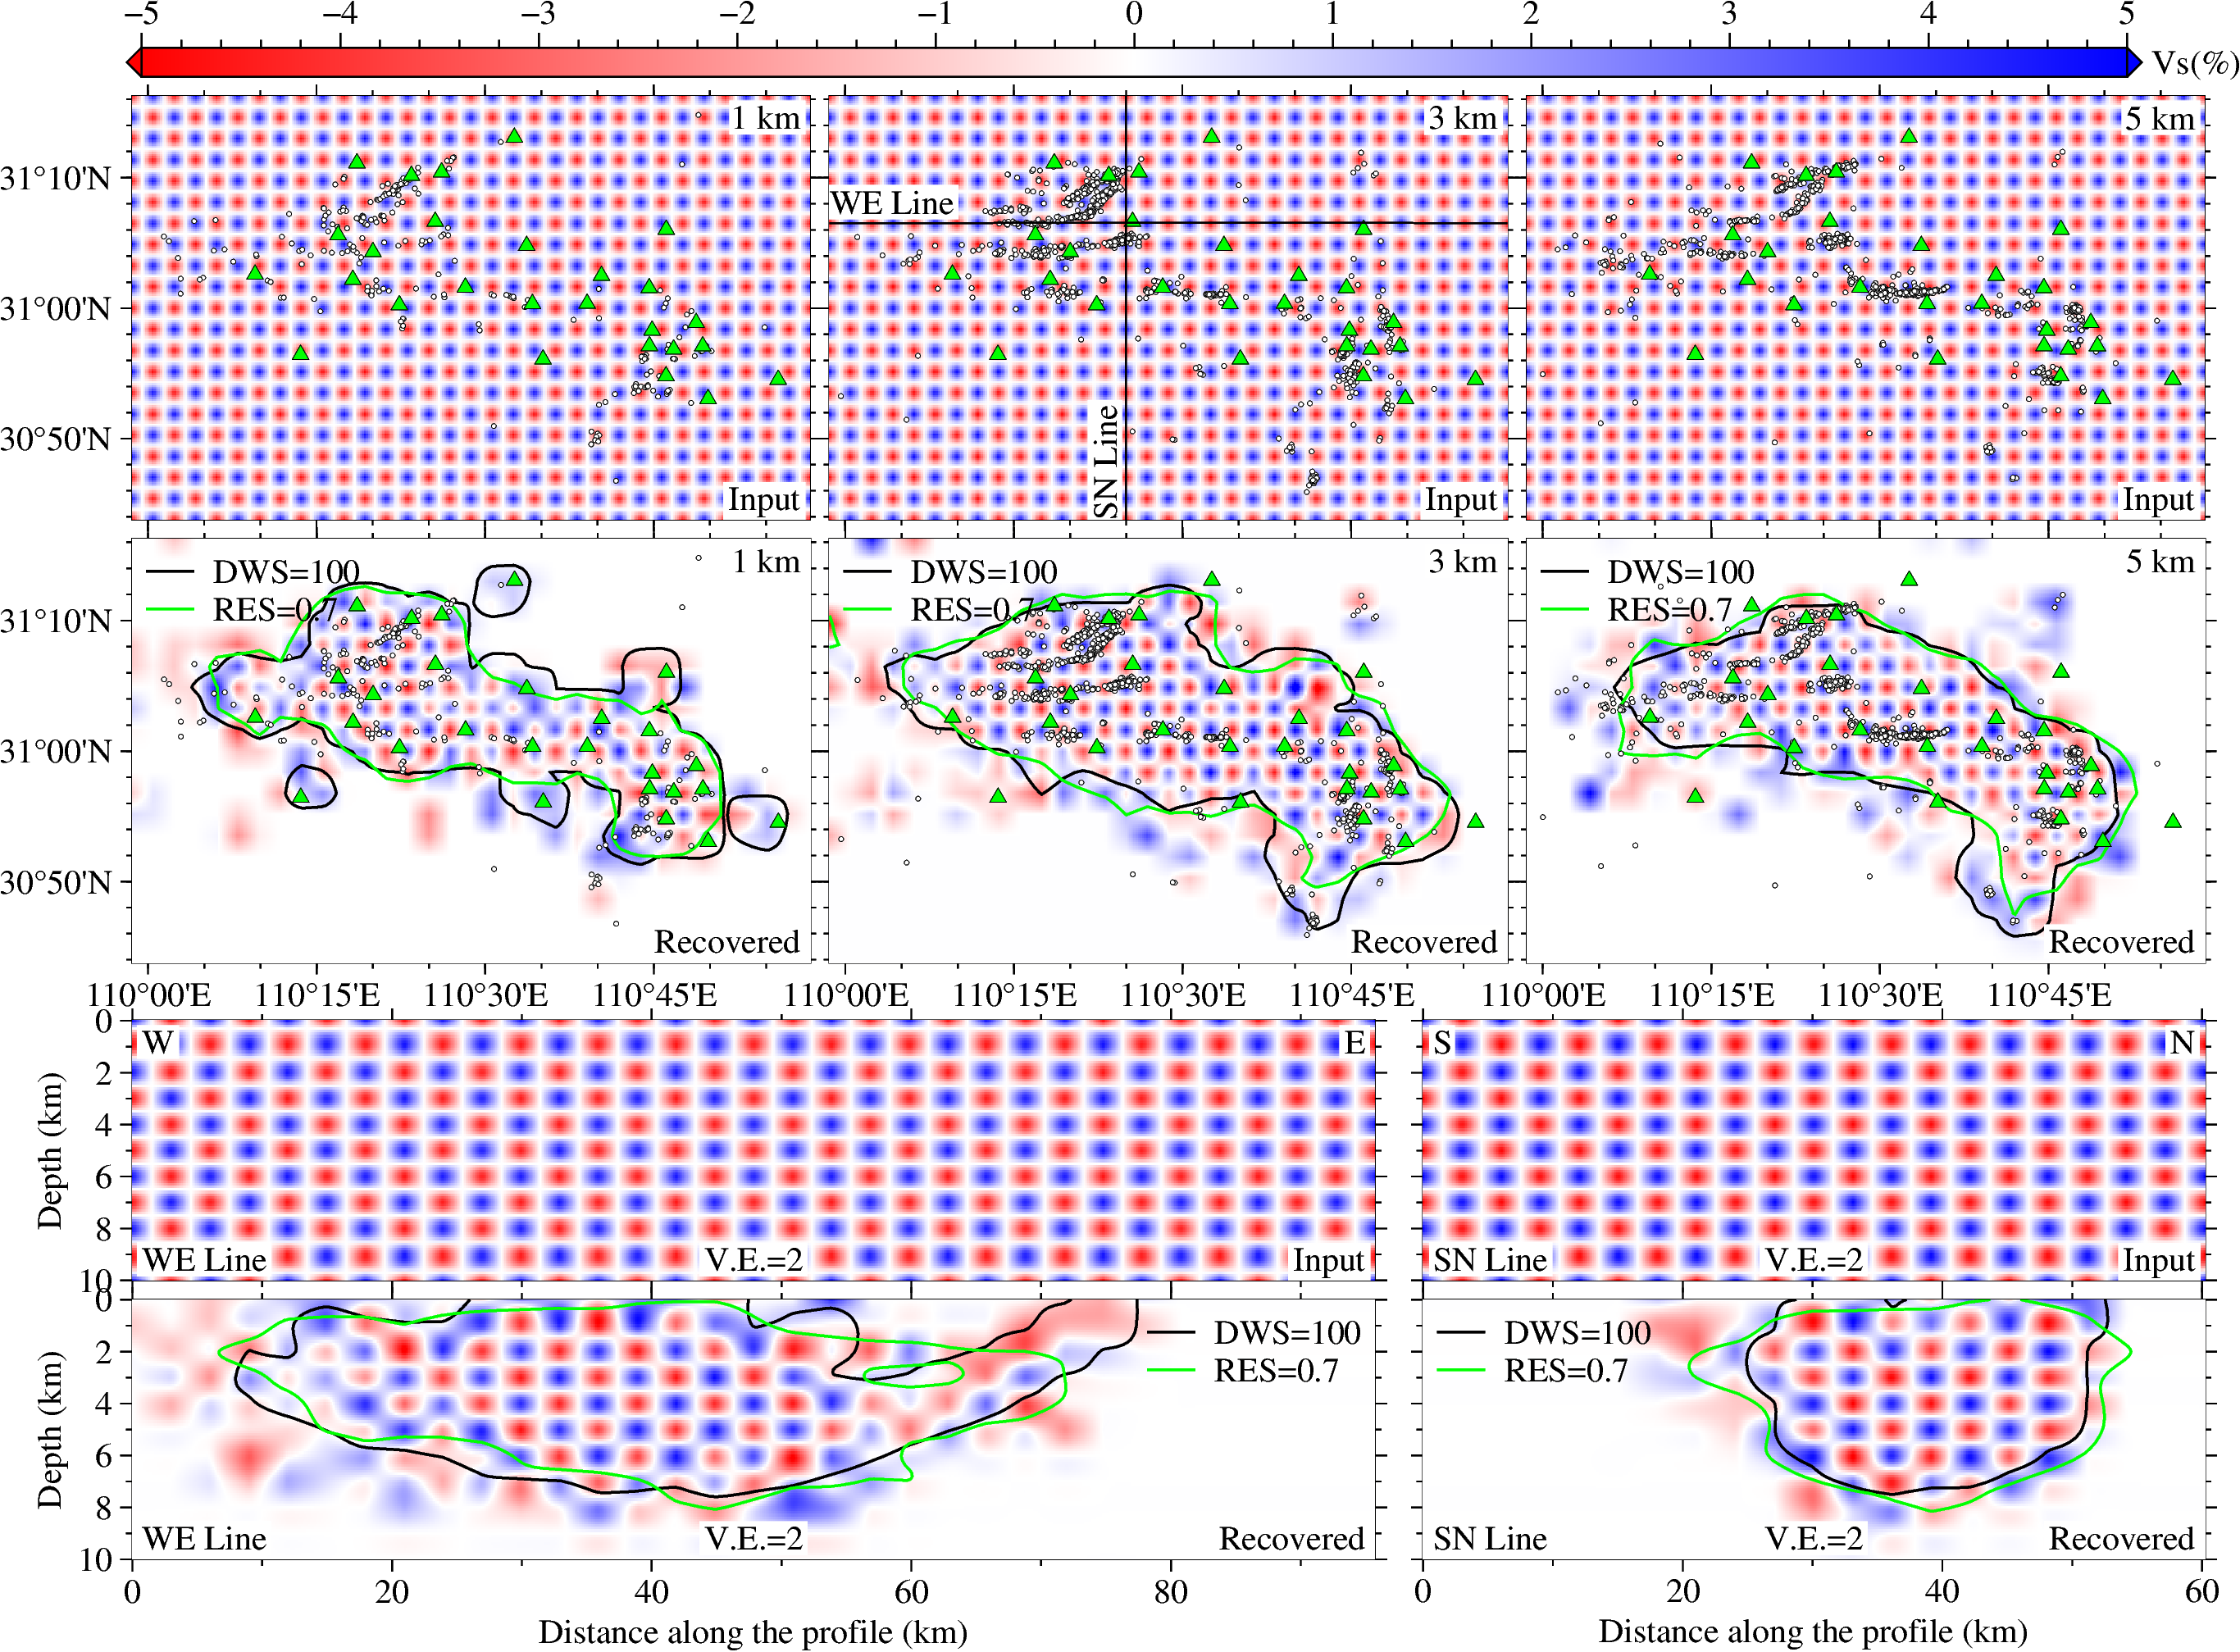

In [29]:
# plot
scale = (21+0.4-0.5)/(p_region_1[1]+p_region_2[1])
fig.shift_origin(xshift='-{}c'.format(7.0*2+0.4),yshift='-{}c'.format(10*scale*2+0.6))
#fig = pygmt.Figure()
#pygmt.config(FONT='8p,4',COLOR_NAN='128',MAP_FRAME_TYPE='plain',MAP_FRAME_PEN='0.5p')
fig.basemap(region=[0,p_region_1[1],0,10],projection=f'x{scale}c/-{2*scale}c',frame=['xaf','yaf+lDepth (km)','Wsen'])
fig.grdimage(grid=grid1*100,cmap='chk.cpt')
fig.text(position='cTL',text='W',fill='white',offset='0.1c/-0.1c')
fig.text(position='cTR',text='E',fill='white',offset='-0.1c/-0.1c')
fig.text(position='cBL',text='WE Line',fill='white',offset='0.1c/0.1c')
fig.text(position='cBR',text='Input',fill='white',offset='-0.1c/0.1c')
fig.text(position='cBC',text='V.E.=2',fill='white',offset='0c/0.1c')

fig.shift_origin(yshift='-{}c'.format(10*scale*2+0.2))
fig.basemap(region=[0,p_region_1[1],0,10],projection=f'x{scale}c/-{2*scale}c',frame=['xaf+lDistance along the profile (km)','yaf+lDepth (km)','WSen'])
fig.grdimage(grid=grid_vp_perc_1*100,cmap='chk.cpt')
fig.grdcontour(grid=grid_dwsp_1,interval=interval,limit=[interval,interval],pen='0.7p,black',label=label)
fig.grdcontour(grid=grid_resp_1,interval=intervalr,limit=[intervalr,intervalr],pen='0.7p,green',label=labelr)

fig.text(position='cBL',text='WE Line',fill='white',offset='0.1c/0.1c')
fig.text(position='cBR',text='Recovered',fill='white',offset='-0.1c/0.1c')
fig.text(position='cBC',text='V.E.=2',fill='white',offset='0c/0.1c')
fig.legend(position='jTR')

#===============
fig.shift_origin(xshift='{}c'.format(p_region_1[1]*scale+0.5),yshift='{}c'.format(10*scale*2+0.2))
fig.basemap(region=[0,p_region_2[1],0,10],projection=f'x{scale}c/-{2*scale}c',frame=['xaf','yaf+lDepth (km)','wsen'])
fig.grdimage(grid=grid2*100,cmap='chk.cpt')
fig.text(position='cTL',text='S',fill='white',offset='0.1c/-0.1c')
fig.text(position='cTR',text='N',fill='white',offset='-0.1c/-0.1c')
fig.text(position='cBL',text='SN Line',fill='white',offset='0.1c/0.1c')
fig.text(position='cBR',text='Input',fill='white',offset='-0.1c/0.1c')
fig.text(position='cBC',text='V.E.=2',fill='white',offset='0c/0.1c')

fig.shift_origin(yshift='-{}c'.format(10*scale*2+0.2))
fig.basemap(region=[0,p_region_2[1],0,10],projection=f'x{scale}c/-{2*scale}c',frame=['xaf+lDistance along the profile (km)','yaf+lDepth (km)','wSen'])
fig.grdimage(grid=grid_vp_perc_2*100,cmap='chk.cpt')
fig.grdcontour(grid=grid_dwsp_2,interval=interval,limit=[interval,interval],pen='0.7p,black',label=label)
fig.grdcontour(grid=grid_resp_2,interval=intervalr,limit=[intervalr,intervalr],pen='0.7p,green',label=labelr)

fig.text(position='cBL',text='SN Line',fill='white',offset='0.1c/0.1c')
fig.text(position='cBR',text='Recovered',fill='white',offset='-0.1c/0.1c')
fig.text(position='cBC',text='V.E.=2',fill='white',offset='0c/0.1c')
fig.legend(position='jTL')
fig.show()

In [30]:
fig.savefig(f'plotting_figures/Figure10_{resname}_{wv}_checkerboard.png',dpi=600)
fig.savefig(f'plotting_figures/Figure10_{resname}_{wv}_checkerboard.pdf')

In [31]:
f'plotting_figures/Figure10_{resname}_{wv}_checkerboard.png'

'plotting_figures/Figure10_3_s_checkerboard.png'

In [32]:
# remove data
for file in glob.glob('*.cpt'):
    os.remove(file)